# _Initial DL Model Exploration: Dec. 31, 2019_

In [ ]:
# update pytorch and fastai to latest versions
!pip install torch -U
!pip install torchvision -U
!pip install fastai -U 

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# import deep learning libraries
from fastai.text import *
import torch
import fastai
from fastai import *

In [ ]:
# import libraries
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import random
import os

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

In [7]:
# mount your google drive so you can save to it
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## _Set-up Directory_

In [8]:
# current directory
os.getcwd()

'/content'

In [ ]:
# change to appropriate directory for this project
os.chdir('/content/gdrive/My Drive/projects/Russian-Disinformation')

In [10]:
# ensure directory has been updated
print('Current directory: {}'.format(os.getcwd()))

Current directory: /content/gdrive/My Drive/projects/Russian-Disinformation


In [11]:
current_directory = os.getcwd()
current_directory

'/content/gdrive/My Drive/projects/Russian-Disinformation'

In [ ]:
# set up FASTAI home variable to download data to appropriate directory
os.environ['FASTAI_HOME'] = current_directory
#os.environ["TORCH_HOME"] = current_directory

In [13]:
os.environ.get('FASTAI_HOME')

'/content/gdrive/My Drive/projects/Russian-Disinformation'

In [14]:
from pathlib import Path

# store currect directory for easier access
current_directory = os.getcwd()
path = Path(current_directory)
path.ls()

[PosixPath('/content/gdrive/My Drive/projects/Russian-Disinformation/verified_train.json'),
 PosixPath('/content/gdrive/My Drive/projects/Russian-Disinformation/ml_sample20.json'),
 PosixPath('/content/gdrive/My Drive/projects/Russian-Disinformation/ira_train.json'),
 PosixPath('/content/gdrive/My Drive/projects/Russian-Disinformation/config.yml')]

## _Load in Data_

In [ ]:
# load in ML sample data
df = pd.read_json("ml_sample20.json", orient="split")

In [16]:
# see first few rows
df[:5]

,id_str,screen_name,created_at,lang,source,retweet_count,favorite_count,full_text,clean_text,label
0,561424233624915968,DailyLosAngeles,2015-01-31 07:22:00,en,twitterfeed,0,0,San Francisco police detain 2 in dismembered b...,San Francisco police detain 2 in dismembered b...,fake
1,1159709950018539520,MeekMill,2019-08-09 06:16:13,en,Twitter for iPhone,4,25,@PrimeVideo then call it a night!! https://t.c...,PrimeVideo then call it a night,real
2,68709491461464064,ActuallyNPH,2011-05-12 16:09:53,en,Twitter Web Client,99,18,"NYers: I'm trying to find a simple, furnished ...",NYers Im trying to find a simple furnished sub...,real
3,560767739833241600,363c7ee353649189abbdd829bc73b38dae50070b48c5fa...,2015-01-29 11:53:00,en,Twitter Web Client,0,0,"Intention is not a thought in your mind, it is...",Intention is not a thought in your mind it is ...,fake
4,841727127808434176,a95a911dd6ae864c48ed062cdbe75e5c28dbe0cf57c6db...,2017-03-14 19:06:00,en,Twitter Web Client,1,0,Trump has NOTHING to do with Russia. https://t...,Trump has NOTHING to do with Russia,fake


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337766 entries, 0 to 337765
Data columns (total 10 columns):
id_str            337766 non-null int64
screen_name       337766 non-null object
created_at        337766 non-null datetime64[ns]
lang              337766 non-null object
source            337766 non-null object
retweet_count     337766 non-null int64
favorite_count    337766 non-null int64
full_text         337766 non-null object
clean_text        337766 non-null object
label             337766 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 28.3+ MB


In [ ]:
import numpy as np
from numpy.random import choice

# set seed
np.random.seed(1)

# create new column indicating if it is part of validation set or not
df["valid"] = pd.Series(choice([True, False], size=len(df), p=[0.7, 0.3]))

In [19]:
df["valid"].value_counts(normalize=True)

True     0.699807
False    0.300193
Name: valid, dtype: float64

In [ ]:
# create copy of DF with relevant info
df = df[["full_text", "label", "valid"]].copy()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337766 entries, 0 to 337765
Data columns (total 3 columns):
full_text    337766 non-null object
label        337766 non-null object
valid        337766 non-null bool
dtypes: bool(1), object(2)
memory usage: 8.1+ MB


## _Creating the TextLMDataBunch_

In [22]:
# create data object with data block API
data_lm = (TextList.from_df(
    df=df,
    path=path,
    cols="full_text")
.split_by_rand_pct(0.1, seed=1)
.label_for_lm()
.databunch(bs=48, num_workers=1)
)

In [23]:
# see what a batch looks like
data_lm.show_batch()

idx,text
0,"is not a thought in your mind , it is the power you employ to create your world . xxmaj it is xxmaj intention that manifests your choices . xxup -jcw xxbos xxmaj trump has xxup nothing to do with xxmaj russia . https : / / t.co / xxunk xxbos xxmaj man records passenger on xxup metro bus harassing elderly woman # news xxbos xxmaj golf : xxmaj palmer"
1,xxup u.s. lawmaker voted xxbos xxmaj yes https : / / t.co / xxunk xxbos xxmaj tillerson used email alias at xxmaj exxon to talk climate : xxmaj new xxmaj york attorney general https : / / t.co / xxunk xxbos xxmaj la comunidad internacional debe tener claro que el xxunk cualquier tipo de xxunk a xxmaj maduro o el estar xxunk sobre la grave crisis que xxunk # xxmaj
2,"the xxmaj lake xxmaj district 's xxmaj dove xxmaj xxunk offers an unforgettable overnight stay http : / / t.co / xxunk # xxmaj foke xxbos xxmaj monroeville xxmaj mall introduces new youth policy # local xxbos "" xxmaj you should n't feel like you ca n't make mistakes at this point . "" — xxmaj president xxmaj obama to xxmaj noah mcqueen http : / / t.co / xxunk"
3,men for sex . https : / / t.co / xxunk xxbos xxup sdf forces capture and dismantle thousands of bombs and ieds in # xxmaj manbij https : / / t.co / xxunk g xxbos @bojangles1977 what ’s good tho i want more xxbos @38540d3111e61e3815faf16d4230b2fca6116c55c3ac4cb899a1257c49db9c84 no doubt xxbos xxmaj midshipmen create ' xxmaj xxunk xxmaj funk ' video # xxmaj maryland xxbos “ xxmaj the xxmaj james xxup w.
4,"/ / t.co / xxunk xxbos xxmaj creator of covert xxmaj planned xxmaj parenthood videos in the spotlight # xxmaj texas xxbos lebron arrives to watch xxmaj bronny and xxmaj sierra xxmaj canyon play against his alma mater , xxmaj st. xxmaj vincent - xxmaj st . xxmaj mary . \n \n xxmaj watch live now 🍿 https : / / t.co / xxunk https : / / t.co"


In [ ]:
# save databunch for next time
data_lm.save("models/lm_databunch")

## _Loading Saved Data, and Creating the Language Model_

In [ ]:
data_lm = load_data(path/"models", "lm_databunch", bs=48)

In [ ]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
wiki_itos = pickle.load(open(path/"models/wt103-fwd/itos_wt103.pkl", "rb"))

In [ ]:
# load vocabulary of language model
vocab = data_lm.vocab

In [35]:
vocab.stoi["stingray"]

39210

In [36]:
vocab.itos[vocab.stoi['stingray']]

'stingray'

In [37]:
vocab.itos[vocab.stoi['mobula']]

'xxunk'

In [ ]:
awd = learn_lm.model[0]

In [ ]:
from scipy.spatial.distance import cosine as dist

In [40]:
enc = learn_lm.model[0].encoder
enc.weight.size()

torch.Size([47424, 400])

## _Training the Model_

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


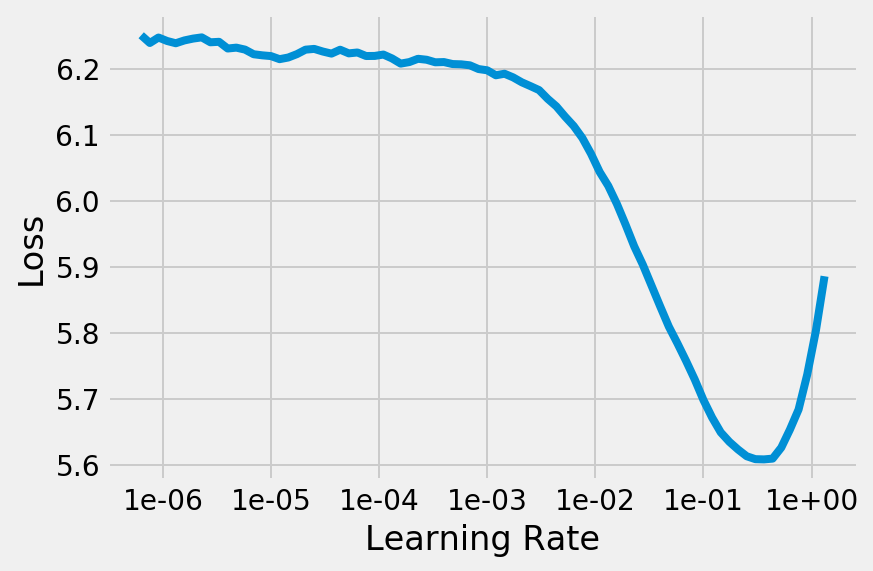

In [43]:
learn_lm.lr_find()
learn_lm.recorder.plot(skip_end=10)

In [ ]:
lr = 1e-2

In [ ]:
learn_lm.to_fp16();

In [47]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.051777,3.844542,0.387903,06:21


In [ ]:
learn_lm.save("fit_1");

In [ ]:
learn_lm.load("fit_1");

## _Unfreeze and Fine-Tune_

In [ ]:
learn_lm.unfreeze()

In [53]:
learn_lm.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.490181,3.429500,0.430497,07:17
1,3.515878,3.440743,0.428371,07:16
2,3.477211,3.395124,0.433380,07:16
3,3.377501,3.312061,0.443051,07:16
4,3.293699,3.234850,0.451220,07:16
5,3.157233,3.152229,0.461087,07:16
6,3.025581,3.073155,0.471943,07:16
7,2.861168,3.011769,0.481317,07:16
8,2.722441,2.987064,0.486680,07:17
9,2.589486,2.991396,0.487331,07:17


In [ ]:
learn_lm.save("fine_tuned")

In [ ]:
learn_lm.save_encoder("fine_tuned_enc")

## _Loading our saved weights_

In [ ]:
learn_lm.load("fine_tuned");

## _Classifier_

In [57]:
df.columns

Index(['full_text', 'label', 'valid'], dtype='object')

In [74]:
# create data object with data block API
data_clas = (TextList.from_df(
    df=df,
    path=path,
    vocab=data_lm.vocab,
    cols="full_text")
.split_by_rand_pct(0.3, seed=1)
.label_from_df(cols="label")
.databunch(bs=48, num_workers=1)
)

In [75]:
data_clas

TextClasDataBunch;

Train: LabelList (236437 items)
x: TextList
xxbos xxmaj san xxmaj francisco police detain 2 in dismembered body case # crime,xxbos nyers : i 'm trying to find a simple , xxunk xxunk for our nanny in the xxmaj upper xxmaj west xxmaj side - ish area for a month or so . xxmaj any leads ?,xxbos xxmaj intention is not a thought in your mind , it is the power you employ to create your world . xxmaj it is xxmaj intention that manifests your choices . xxup -jcw,xxbos xxmaj man records passenger on xxup metro bus harassing elderly woman # news,xxbos xxmaj golf : xxmaj palmer lauded by greats of the sport at memorial service # sports
y: CategoryList
fake,real,fake,fake,fake
Path: /content/gdrive/My Drive/projects/Russian-Disinformation;

Valid: LabelList (101329 items)
x: TextList
xxbos xxmaj that 's why i pick and choose , i do n't get shit confused,xxbos # news xxmaj protest over xxmaj chicago teen ’s shooting ties up retail district,xxbos 🎧 xxmaj listen : xxmaj federal off

In [ ]:
data_clas.save("ru_twitter_sample_class")

In [ ]:
data_clas = load_data(path, "ru_twitter_sample_class", bs=48);

In [78]:
data_clas.show_batch()

text,target
xxbos xxrep 5 🌠 🇺 🇸 🇺 🇸 🇺 🇸 🇺 🇸 🇺 🇸 🇺 🇸 🇺 🇸 \n xxrep 5 🌠 ⚾ ️ ⚾ ️ ⚾ ️ ⚾ ️ ⚾ ️ ⚾ ️ ⚾ ️ \n xxrep 5 🌠 🇺 🇸 🇺 🇸 🇺 🇸 🇺 🇸 🇺 🇸 🇺 🇸 🇺 🇸 \n xxrep 5 🌠 ⚾ ️ ⚾ ️ ⚾ ️ ⚾ ️ ⚾,real
"xxbos “ xxmaj the first threat is , ‘ xxmaj if you do n’t do it , i ’m going to post on social media , ’ ” said xxmaj matt xxmaj wright , a special agent with the xxmaj department of xxmaj homeland xxmaj security . “ ‘ xxmaj and by the way , i ’ve got a list of your family members and i ’m going to send",real
xxbos xxmaj here are the 10 candidates in tonight 's # demdebate : \n \n 🗣 ️ xxmaj joe xxmaj biden \n 🗣 ️ xxmaj cory xxmaj booker \n 🗣 ️ xxmaj pete xxmaj buttigieg \n 🗣 ️ xxmaj tulsi xxmaj gabbard \n 🗣 ️ xxmaj kamala xxmaj harris \n 🗣 ️ xxmaj amy xxmaj klobuchar \n 🗣 ️ xxmaj bernie xxmaj sanders,real
"xxbos xxmaj rep. xxmaj dean : “ xxmaj some have suggested that our actions , this historic call for impeachment , are based in dislike , or even hatred , of a single man . xxmaj they are not . xxmaj this is not about punishment or hate . xxmaj it is about love . xxmaj it is about love of this",real
"xxbos xxmaj actor xxmaj kevin xxmaj costner , the star of "" xxmaj field of xxmaj dreams "" and "" xxmaj dances xxmaj with xxmaj wolves , "" will endorse xxmaj south xxmaj bend , xxmaj indiana , xxmaj mayor xxmaj pete xxmaj buttigieg this weekend , the campaign announced . xxmaj the two - time xxmaj academy xxmaj award winner will introduce xxmaj buttigieg in xxmaj iowa . https",real


In [79]:
data_clas

TextClasDataBunch;

Train: LabelList (236437 items)
x: TextList
xxbos xxmaj san xxmaj francisco police detain 2 in dismembered body case # crime,xxbos nyers : i 'm trying to find a simple , xxunk xxunk for our nanny in the xxmaj upper xxmaj west xxmaj side - ish area for a month or so . xxmaj any leads ?,xxbos xxmaj intention is not a thought in your mind , it is the power you employ to create your world . xxmaj it is xxmaj intention that manifests your choices . xxup -jcw,xxbos xxmaj man records passenger on xxup metro bus harassing elderly woman # news,xxbos xxmaj golf : xxmaj palmer lauded by greats of the sport at memorial service # sports
y: CategoryList
fake,real,fake,fake,fake
Path: /content/gdrive/My Drive/projects/Russian-Disinformation;

Valid: LabelList (101329 items)
x: TextList
xxbos xxmaj that 's why i pick and choose , i do n't get shit confused,xxbos # news xxmaj protest over xxmaj chicago teen ’s shooting ties up retail district,xxbos 🎧 xxmaj listen : xxmaj federal off

In [ ]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn_c.to_fp16();

In [ ]:
learn_c.load_encoder("models/fine_tuned_enc");

In [ ]:
learn_c.freeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


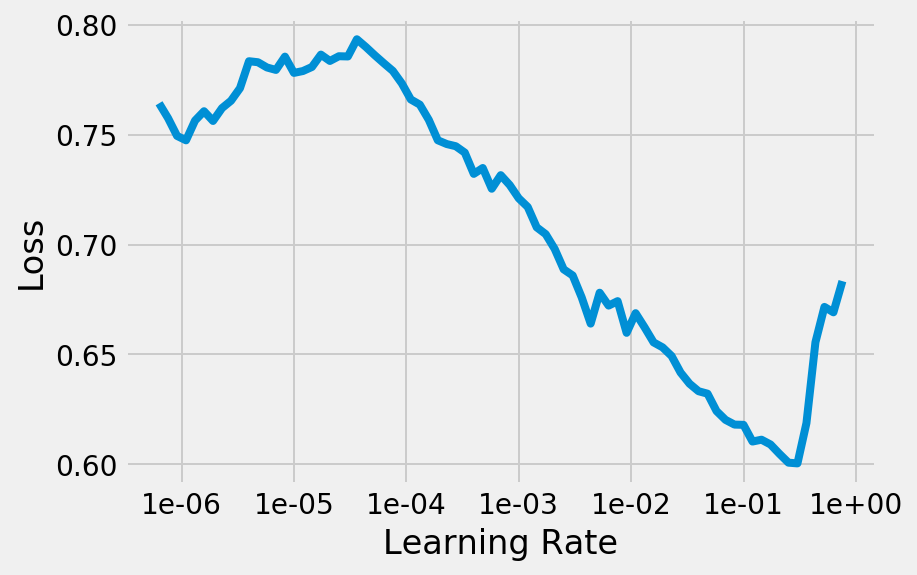

In [84]:
learn_c.lr_find()
learn_c.recorder.plot()

In [ ]:
lr = 1e-3

In [86]:
learn_c.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.264911,0.162431,0.939524,02:05


In [ ]:
learn_c.save("first_ru_clas")

In [ ]:
learn_c.load("first_ru_clas");

In [89]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4), 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.156783,0.123924,0.952886,02:40


In [ ]:
learn_c.save("second_ru_clas");

In [ ]:
learn_c.load("second_ru_clas");

In [92]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4), 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.140594,0.122699,0.951653,03:36
1,0.135032,0.112554,0.956834,03:32


In [ ]:
learn_c.save("third_ru_clas");

In [ ]:
learn_c.load("third_ru_clas");

In [95]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.119768,0.110984,0.957376,05:07
1,0.124963,0.105616,0.959548,05:15


In [ ]:
learn_c.save("fin_ru_clas")

## _Create Test Set_

In [ ]:
# load in test data for IRA and Verified Users
ira = pd.read_json("json_data/ira_test.json", orient="split")
verified = pd.read_json("json_data/verified_test.json", orient="split")

In [97]:
ira.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381328 entries, 0 to 381327
Data columns (total 10 columns):
id_str            381328 non-null int64
screen_name       381328 non-null object
created_at        381328 non-null datetime64[ns]
lang              381328 non-null object
source            381328 non-null object
retweet_count     381328 non-null int64
favorite_count    381328 non-null int64
full_text         381328 non-null object
clean_text        381328 non-null object
label             381328 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 32.0+ MB


In [98]:
verified.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42221 entries, 0 to 42220
Data columns (total 10 columns):
id_str            42221 non-null int64
screen_name       42221 non-null object
created_at        42221 non-null datetime64[ns]
lang              42221 non-null object
source            42221 non-null object
retweet_count     42221 non-null int64
favorite_count    42221 non-null int64
full_text         42221 non-null object
clean_text        42221 non-null object
label             42221 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 3.5+ MB


In [ ]:
# generate samples for both IRA and Verified
ira_sample = ira.sample(n=500, random_state=1)
verif_sample = verified.sample(n=500, random_state=1)

In [107]:
combined = pd.concat([ira_sample, verif_sample])
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 25179 to 10893
Data columns (total 10 columns):
id_str            1000 non-null int64
screen_name       1000 non-null object
created_at        1000 non-null datetime64[ns]
lang              1000 non-null object
source            1000 non-null object
retweet_count     1000 non-null int64
favorite_count    1000 non-null int64
full_text         1000 non-null object
clean_text        1000 non-null object
label             1000 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 85.9+ KB


In [ ]:
# extract two columns of interest
test = combined[["full_text", "label"]].copy()

In [ ]:
# shuffle data set
test = test.copy().sample(frac=1, random_state=1)

In [ ]:
test.reset_index(drop=True, inplace=True)

In [111]:
test[:5]

,full_text,label
0,The United States needs to end the internation...,real
1,John Dingell was a good man who served the sta...,real
2,Catch up on the best new dining spots http://t...,fake
3,Indian army battles deadly flooding to rescue ...,fake
4,Motorcyclist Killed In Crash On Interstate 880...,fake


In [124]:
learn_c.data.classes

['fake', 'real']

In [131]:
# predict on first observation
predict1 = learn_c.predict(test["full_text"][0])
predict1

(Category real, tensor(1), tensor([2.6634e-04, 9.9973e-01]))

In [132]:
# predict on third observation
predict3 = learn_c.predict(test["full_text"][3])
predict3

(Category fake, tensor(0), tensor([0.9978, 0.0022]))

In [ ]:
# try to get predictions by applying predict to test DF
test_predictions = test["full_text"].apply(learn_c.predict)

In [139]:
test["test_predictions"] = pd.Series(test_predictions)
test[:5]

,full_text,label,test_predictions
0,The United States needs to end the internation...,real,"(real, tensor(1), [tensor(0.0003), tensor(0.99..."
1,John Dingell was a good man who served the sta...,real,"(real, tensor(1), [tensor(4.5170e-26), tensor(..."
2,Catch up on the best new dining spots http://t...,fake,"(fake, tensor(0), [tensor(0.9930), tensor(0.00..."
3,Indian army battles deadly flooding to rescue ...,fake,"(fake, tensor(0), [tensor(0.9978), tensor(0.00..."
4,Motorcyclist Killed In Crash On Interstate 880...,fake,"(fake, tensor(0), [tensor(0.9996), tensor(0.00..."


In [148]:
[str(pred[0]) for pred in test_predictions[:10]]

['real',
 'real',
 'fake',
 'fake',
 'fake',
 'real',
 'fake',
 'real',
 'fake',
 'fake']

In [ ]:
test["test_labels"] = pd.Series([str(pred[0]) for pred in test["test_predictions"]])

In [ ]:
# convert label and test_labels columns to categorical types
test["label"] = test["label"].astype("category")
test["test_labels"] = test["test_labels"].astype("category")

In [152]:
(test["label"] == test["test_labels"]).mean()

0.964

In [164]:
from sklearn.metrics import f1_score

print("The F1 score for the test set: {}".format(f1_score(
    y_true=test["label"], y_pred=test["test_labels"], pos_label="fake")))

The F1 score for the test set: 0.964


In [165]:
test["test_labels"].unique()

[real, fake]
Categories (2, object): [real, fake]

In [167]:
from sklearn.metrics import classification_report

classification_report(y_true=test["label"], y_pred=test["test_labels"], labels=["real", "fake"], output_dict=True)

{'accuracy': 0.964,
 'fake': {'f1-score': 0.964,
  'precision': 0.964,
  'recall': 0.964,
  'support': 500},
 'macro avg': {'f1-score': 0.964,
  'precision': 0.964,
  'recall': 0.964,
  'support': 1000},
 'real': {'f1-score': 0.964,
  'precision': 0.964,
  'recall': 0.964,
  'support': 500},
 'weighted avg': {'f1-score': 0.964,
  'precision': 0.964,
  'recall': 0.964,
  'support': 1000}}

In [170]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true=test["label"], y_pred=test["test_labels"])

array([[482,  18],
       [ 18, 482]])

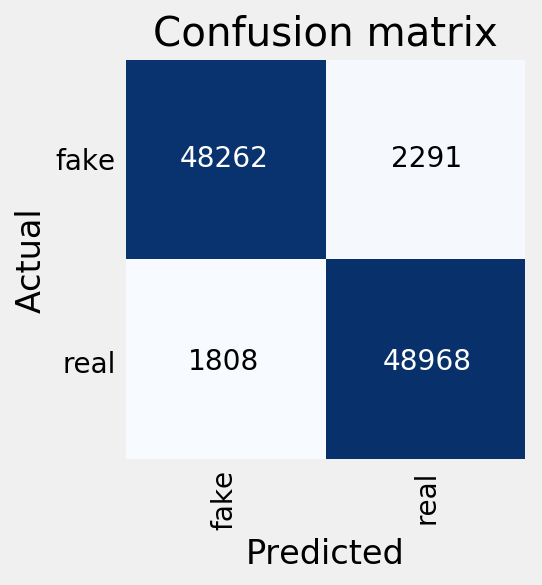

In [160]:
interp.plot_confusion_matrix()

In [ ]:
# check out observations that were incorrect
incorrect = test[test["label"] != test["test_labels"]]